In [8]:
Agent()

__main__.Agent

In [ ]:
class LSTM(BaseRNN):
    def make_params(self, config):
        self.rnn = nn.LSTMCell(input_size=self.env_spec.observation_space.flat_dim, 
                               hidden_size=config['network.hidden_sizes'][0])  # TODO: support multi-layer
        self.last_feature_dim = config['network.hidden_sizes'][-1]
        
    def init_params(self, config):
        ortho_init(self.rnn, nonlinearity=None, weight_scale=1.0, constant_bias=0.0)
    
    def init_hidden_states(self, config, batch_size, **kwargs):
        h = torch.zeros(batch_size, config['network.hidden_sizes'][0])
        h = h.to(self.device)
        c = torch.zeros_like(h)

        return [h, c]
        
    def rnn_forward(self, x, hidden_states, mask=None, **kwargs):
        if mask is not None:
            mask = mask.to(self.device)
            
            h, c = hidden_states
            h = h*mask
            c = c*mask
            hidden_states = [h, c]
            
        h, c = self.rnn(x, hidden_states)
        
        out = {'output': h, 'hidden_states': [h, c]}

        return out


In [9]:
from pathlib import Path
from lagom.experiment import Configurator

from lagom import pickle_load

from lagom.core.plotter import CurvePlot

In [10]:
log_folder = Path('logs')

list_config = pickle_load(log_folder/'configs.pkl')
configs = Configurator.to_dataframe(list_config)
configs

ID  cuda          env.id  env.standardize  network.recurrent  \
0   0  True  HalfCheetah-v2             True               True   

  network.hidden_sizes  algo.lr  algo.use_lr_scheduler  algo.gamma  \
0                 [32]    0.001                   True        0.99   

   agent.standardize_Q   ...     agent.constant_std  \
0                 True   ...                   None   

   agent.std_state_dependent  agent.init_std train.timestep train.N  train.T  \
0                      False             1.0      1000000.0       1      200   

   eval.N  log.record_interval  log.print_interval  log.dir  
0      10                  100                 500     logs  

[1 rows x 24 columns]

In [11]:
def load_results(log_folder, ID, f):
    p = Path(log_folder)/str(ID)
    
    list_result = []
    for sub in p.iterdir():
        if sub.is_dir() and (sub/f).exists():
            list_result.append(pickle_load(sub/f))
            
    return list_result


def get_returns(list_result):
    returns = []
    for result in list_result:
        #x_values = [i['evaluation_iteration'][0] for i in result]
        x_values = [i['accumulated_trained_timesteps'][0] for i in result]
        y_values = [i['average_return'][0] for i in result]
        returns.append([x_values, y_values])
        
    return returns


In [12]:
ID = 0
env_id = configs.loc[configs['ID'] == ID]['env.id'].values[0]

In [13]:
list_result = load_results('logs', ID, 'eval_logs.pkl')
returns = get_returns(list_result)
x_values, y_values = zip(*returns)

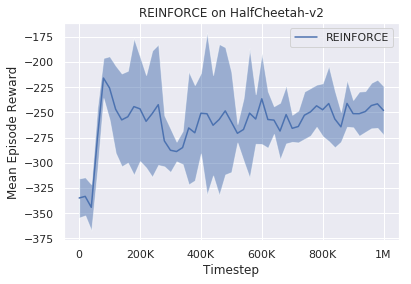

In [14]:
plot = CurvePlot()
plot.add('REINFORCE', y_values, xvalues=x_values)
ax = plot(title=f'REINFORCE on {env_id}', 
          xlabel='Timestep', 
          ylabel='Mean Episode Reward', 
          num_tick=6, 
          xscale_magnitude=None)

In [8]:
ax.figure.savefig('data/result.png')